In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
from PIL import Image
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers

In [3]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


Version:  2.13.0
Eager mode:  True
Hub version:  0.14.0
GPU is available


In [4]:
data_dir = os.path.dirname('./PlantVillage/')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [5]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

In [6]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

total images for training : ./PlantVillage/train : 43444files
total images for validation : ./PlantVillage/validation : 10861files


In [7]:
import json

with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [8]:
print('Number of classes:',len(classes))

Number of classes: 38


In [9]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="./tf2-preview_inception_v3_feature_vector_4/"
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using ./tf2-preview_inception_v3_feature_vector_4/ with input size (299, 299) and output dimension 2048


In [10]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 10861 images belonging to 38 classes.
Found 43444 images belonging to 38 classes.


In [11]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

2023-09-24 04:20:20.326933: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-09-24 04:20:20.326956: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-09-24 04:20:20.326967: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-09-24 04:20:20.327411: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-24 04:20:20.327448: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [13]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with ./tf2-preview_inception_v3_feature_vector_4/
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                19494     
                                                                 
Total params: 22871366 (87.25 MB)
Trainable params: 1068582 (4.08 MB)
Non-trainable params: 21802784 (83.17 MB)
___________

In [14]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [16]:

EPOCHS=5 #@param {type:"integer"}
from PIL import *
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/5
678/678 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.8346

2023-09-24 13:14:24.880816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


678/678 [==============================] - 1254s 2s/step - loss: 0.5491 - accuracy: 0.8346 - val_loss: 0.3972 - val_accuracy: 0.8692
Epoch 2/5
678/678 [==============================] - 1259s 2s/step - loss: 0.4719 - accuracy: 0.8571 - val_loss: 0.3465 - val_accuracy: 0.8903
Epoch 3/5
678/678 [==============================] - 1232s 2s/step - loss: 0.4413 - accuracy: 0.8700 - val_loss: 0.3683 - val_accuracy: 0.8861
Epoch 4/5
678/678 [==============================] - 1483s 2s/step - loss: 0.4215 - accuracy: 0.8803 - val_loss: 0.3757 - val_accuracy: 0.8891
Epoch 5/5
678/678 [==============================] - 1203s 2s/step - loss: 0.4309 - accuracy: 0.8807 - val_loss: 0.3813 - val_accuracy: 0.8940


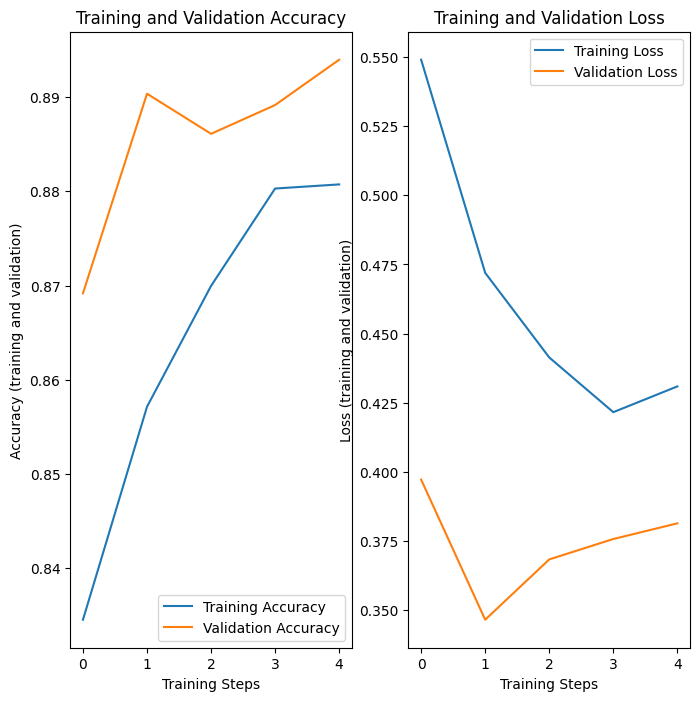

In [18]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [58]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    path=os.path.join(validation_dir, filename)
    print("PATH : ", path)
    img = cv2.imread(path)
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img 


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, file: Tomato___Tomato_Yellow_Leaf_Curl_Virus/3a8fe9a8-1f22-4173-8561-28aaeeb1e7de___UF.GRC_YLCV_Lab 01815.JPG
PATH :  ./PlantVillage/validation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/3a8fe9a8-1f22-4173-8561-28aaeeb1e7de___UF.GRC_YLCV_Lab 01815.JPG


2023-09-24 15:02:59.459687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step
PREDICTED: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.999768


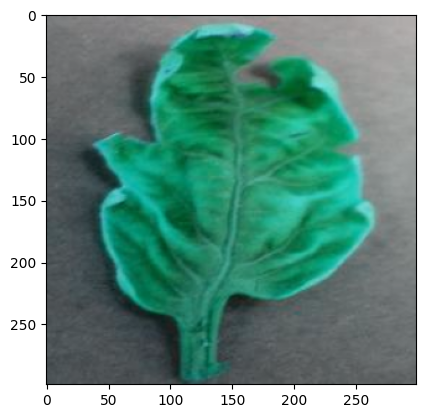

<Figure size 640x480 with 0 Axes>

SOURCE: class: Peach___Bacterial_spot, file: Peach___Bacterial_spot/15032601-ba63-4042-aa25-f6226b9fc7ac___Rutg._Bact.S 1539.JPG
PATH :  ./PlantVillage/validation/Peach___Bacterial_spot/15032601-ba63-4042-aa25-f6226b9fc7ac___Rutg._Bact.S 1539.JPG
1/1 [==============================] - 0s 148ms/step
PREDICTED: class: Tomato___Late_blight, confidence: 0.511028


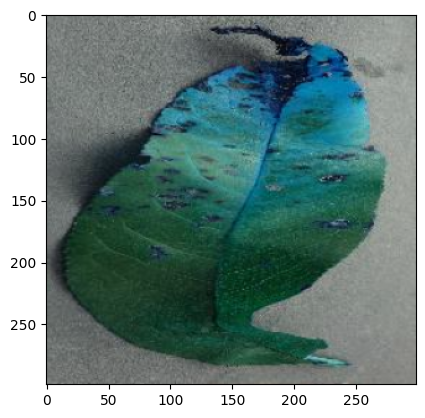

SOURCE: class: Strawberry___Leaf_scorch, file: Strawberry___Leaf_scorch/503e1d1c-8ac3-4984-829d-79be5050e383___RS_L.Scorch 1610.JPG
PATH :  ./PlantVillage/validation/Strawberry___Leaf_scorch/503e1d1c-8ac3-4984-829d-79be5050e383___RS_L.Scorch 1610.JPG
1/1 [==============================] - 0s 133ms/step
PREDICTED: class: Strawberry___Leaf_scorch, confidence: 0.990619


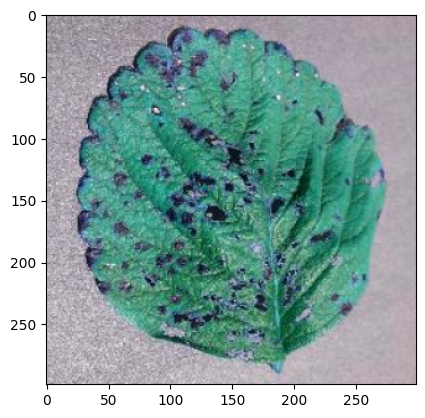

<Figure size 640x480 with 0 Axes>

SOURCE: class: Tomato___Septoria_leaf_spot, file: Tomato___Septoria_leaf_spot/3fc5146d-71b5-4764-8a78-481e098e661e___Matt.S_CG 2752.JPG
PATH :  ./PlantVillage/validation/Tomato___Septoria_leaf_spot/3fc5146d-71b5-4764-8a78-481e098e661e___Matt.S_CG 2752.JPG
1/1 [==============================] - 0s 120ms/step
PREDICTED: class: Tomato___Septoria_leaf_spot, confidence: 0.629257


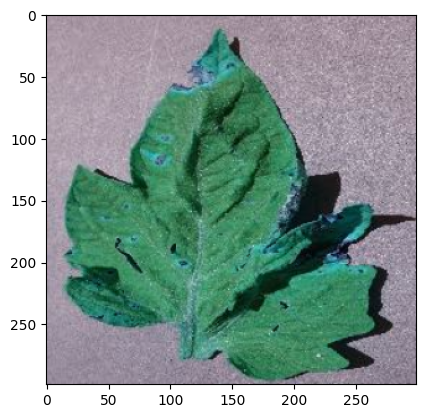

<Figure size 640x480 with 0 Axes>

SOURCE: class: Potato___Early_blight, file: Potato___Early_blight/6319585f-ed2f-4657-ae79-a23db65d0fce___RS_Early.B 7033.JPG
PATH :  ./PlantVillage/validation/Potato___Early_blight/6319585f-ed2f-4657-ae79-a23db65d0fce___RS_Early.B 7033.JPG
1/1 [==============================] - 0s 157ms/step
PREDICTED: class: Potato___Late_blight, confidence: 0.494525


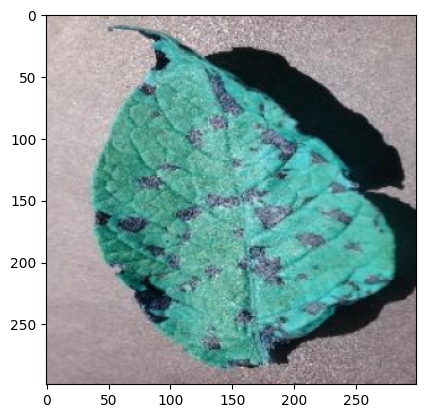

<Figure size 640x480 with 0 Axes>

In [60]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [72]:
import time
t = time.time()

export_path = "./{}".format(int(t))
tf.keras.models.save_model(model, filepath=export_path)

export_path

INFO:tensorflow:Assets written to: ./1695549012/assets


INFO:tensorflow:Assets written to: ./1695549012/assets


'./1695549012'

In [73]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path)

In [74]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([image]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Tomato___Early_blight, file: Tomato___Early_blight/c793a3d2-1f1d-486c-9140-87d2354c4874___RS_Erly.B 7545.JPG
PATH :  ./PlantVillage/validation/Tomato___Early_blight/c793a3d2-1f1d-486c-9140-87d2354c4874___RS_Erly.B 7545.JPG


2023-09-24 15:20:56.831408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
PREDICTED: class: Tomato___Late_blight, confidence: 0.770755


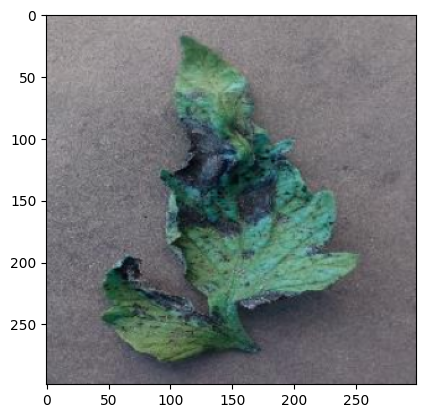

<Figure size 640x480 with 0 Axes>

SOURCE: class: Soybean___healthy, file: Soybean___healthy/8936f6e2-92ee-4608-87a3-aba4b0b03c0f___RS_HL 4761.JPG
PATH :  ./PlantVillage/validation/Soybean___healthy/8936f6e2-92ee-4608-87a3-aba4b0b03c0f___RS_HL 4761.JPG
1/1 [==============================] - 0s 169ms/step
PREDICTED: class: Soybean___healthy, confidence: 0.999998


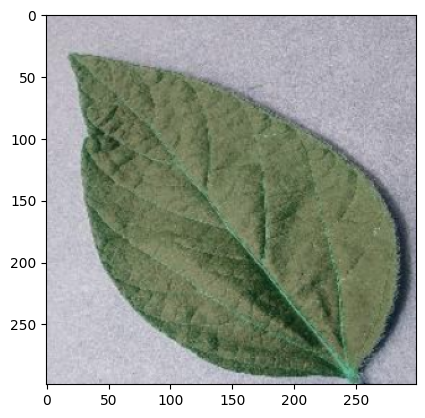

In [75]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [76]:
# convert the model to TFLite
TFLITE_MODEL = "./tflite_models/plant_disease_model.tflite"

# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

2023-09-24 15:22:08.835789: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-09-24 15:22:08.836782: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-09-24 15:22:08.838634: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-24 15:22:08.838652: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-24 15:22:10.540193: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-24 15:22:10.540274: W tensorflow/compiler/m

91554060

In [5]:
diseases = os.listdir(train_dir)

In [6]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [9]:
import pandas as pd
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
        
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Strawberry___healthy,364
Grape___Black_rot,944
Potato___Early_blight,800
Blueberry___healthy,1202
Corn_(maize)___healthy,929
Tomato___Target_Spot,1123
Peach___healthy,288
Potato___Late_blight,800
Tomato___Late_blight,1527
Tomato___Tomato_mosaic_virus,299
